Include Namespaces

In [137]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd

cuda = torch.device('cuda')

Grab data and separate the data into training, validation, target, and training datasets.

In [138]:
train_dataset = pd.read_csv('../input/conways-reverse-game-of-life-2020/train.csv')
train_dataset, val_dataset = random_split(train_dataset, [40000,10000])

train_indx = train_dataset.indices
val_indx = val_dataset.indices

correct_train_data = train_dataset.dataset.iloc[train_indx, 0:627]
correct_val_data = val_dataset.dataset.iloc[val_indx, 0:627]

train_data = train_dataset.dataset.loc[train_indx, ['id', 'delta']]
train_data = pd.concat([train_data, train_dataset.dataset.loc[train_indx, 'stop_0':]], axis=1, sort=False)
val_data = val_dataset.dataset.loc[val_indx, ['id', 'delta']]
val_data = pd.concat([val_data, val_dataset.dataset.loc[val_indx, 'stop_0':]], axis=1, sort=False)

test_data = pd.read_csv('../input/conways-reverse-game-of-life-2020/test.csv')

Define Hyper-parameters

In [139]:
args={}
batch_size = 20
test_batch_size = 1000
epochs = 5
learning_rate = 0.01

Define a custom dataloader

In [140]:
class Training_Data(Dataset):
  def __init__(self, train_data, target_data):
    super().__init__()
    self.train_data = train_data
    self.target_data = target_data

  def __len__(self):
    return len(self.train_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    return (self.train_data[idx], self.target_data[idx])

Define the autoencoder

In [141]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(626, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 32), 
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True), 
            nn.Linear(16, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 625), 
            nn.Sigmoid())


    def forward(self, x):
      code_vector = self.encoder(x)
      output = self.decoder(code_vector)
      return output

ae = autoencoder().cuda()

Define loss function

In [142]:
ae_criterion = nn.BCELoss()

ae_optimizer = torch.optim.Adam([
    {'params': ae.encoder.parameters(), 'lr': learning_rate},
    {'params': ae.decoder.parameters(), 'lr': learning_rate}
  ], lr=learning_rate)

Train autoencoder using the training and validation datasets

In [143]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
training_dataset = Training_Data(train_data.loc[:,'delta':].values.astype(float), correct_train_data.loc[:,'start_0':].values.astype(float))
t_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = Training_Data(val_data.loc[:,'delta':].values.astype(float), correct_val_data.loc[:,'start_0':].values.astype(float))
v_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
for epoch in range(epochs):
    ae.train()
    batch_loss  = []
    running_loss = 0.0
    running_acc = 0
    for board, target in t_loader:
      board, target = board.cuda(), target.cuda()
      output = ae(board.float())
      loss = ae_criterion(output, target.float())
      ae_optimizer.zero_grad()
      loss.backward()
      ae_optimizer.step()
      batch_loss.append(loss.item())
      running_loss += loss.item() * board.shape[0]
      assert output.shape==target.shape
      running_acc += ((output > 0.5)==target).sum().item()

    train_accuracy = (running_acc*100)/(len(training_dataset)*625)
    print(f"Train loss {epoch+1}: {running_loss/len(training_dataset):.4f}, Train Acc:{train_accuracy:.4f}%")
    train_acc.append(train_accuracy)
    train_loss.append(np.mean(batch_loss))

    ae.eval()
    batch_loss  = []
    v_running_acc = 0
    with torch.no_grad():
      for board, target in v_loader:
        board, target = board.cuda(), target.cuda()
        output = ae(board.float())
        loss = ae_criterion(output, target.float())
        v_running_acc += ((output > 0.5)==target).sum().item()
        batch_loss.append(loss.item())
    val_loss.append(np.mean(batch_loss))
    val_accuracy = (v_running_acc*100)/(len(validation_dataset)*625)
    val_acc.append(val_accuracy)
    print('epoch [{}/{}], train loss:{:.4f}, val loss:{:.4f}, val acc: {:.4f}%'
          .format(epoch + 1, epochs, train_loss[-1], val_loss[-1], val_acc[-1]))

Train loss 1: 0.3990, Train Acc:84.0983%
epoch [1/5], train loss:0.3990, val loss:0.3946, val acc: 84.2159%
Train loss 2: 0.3970, Train Acc:84.1222%
epoch [2/5], train loss:0.3970, val loss:0.3943, val acc: 84.2159%
Train loss 3: 0.3966, Train Acc:84.1222%
epoch [3/5], train loss:0.3966, val loss:0.3949, val acc: 84.2159%
Train loss 4: 0.3962, Train Acc:84.1222%
epoch [4/5], train loss:0.3962, val loss:0.3944, val acc: 84.2159%
Train loss 5: 0.3960, Train Acc:84.1222%
epoch [5/5], train loss:0.3960, val loss:0.3941, val acc: 84.2159%


Plot the training and validation loss over time

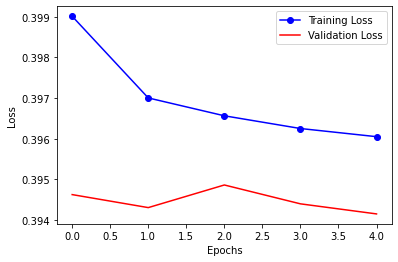

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs_list = range(len(train_loss))
plt.plot(epochs_list, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_list, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get the columns for the submission

In [145]:
sample_submission = pd.read_csv('../input/conways-reverse-game-of-life-2020/sample_submission.csv', index_col='id')
cols = sample_submission.columns

Get predictions from the autoencoder for the test dataset

In [146]:
test_tensor = torch.from_numpy(test_data.values[:,1:])
test_tensor = test_tensor.cuda()
probabilities = ae(test_tensor.float())
predictions = (probabilities > .301).int()

predictions = predictions.data.cpu().numpy()
idx = range(predictions.shape[0], predictions.shape[0]*2)
idfx = pd.DataFrame(idx, columns=['id'])

In [147]:
# (predictions==1).sum().item()
# print("mean: ", probabilities.mean().item())
# print("median: ", probabilities.median().item())
# print("std: ", probabilities.std().item())
# print("max: ", probabilities.max().item())
# print("min: ", probabilities.min().item())
# print(">.34: ", (probabilities > 0.305).sum().item())

Create submission

In [148]:
submission = submission = pd.concat([idfx, pd.DataFrame(predictions, columns=cols)], axis=1)
submission.to_csv("./submission.csv", index=False)